In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn.metrics as m
import sklearn.model_selection as ms
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.ensemble as ensemble
import ml_metrics

In [2]:
data = pd.read_csv('income_evaluation.csv', na_values=[' ?'])
# in my initial assessment, found missing values are represented by " ?"

In [3]:
data.shape[0] - data.count()

age                   0
 workclass         1836
 fnlwgt               0
 education            0
 education-num        0
 marital-status       0
 occupation        1843
 relationship         0
 race                 0
 sex                  0
 capital-gain         0
 capital-loss         0
 hours-per-week       0
 native-country     583
 income               0
dtype: int64

# Data Prep for ML

In [4]:
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
data.shape[0] - data.count() 

age                0
 workclass         0
 fnlwgt            0
 education         0
 education-num     0
 marital-status    0
 occupation        0
 relationship      0
 race              0
 sex               0
 capital-gain      0
 capital-loss      0
 hours-per-week    0
 native-country    0
 income            0
dtype: int64

In [5]:
print(data.columns)
# the values in the column header have trailing spaces in front of the value
# remedy: remove trailing spaces

print()
column_name = [i.replace(' ','') for i in data.columns]
data.columns = column_name
data.replace(' ', '', inplace=True)
print(data.columns) 

Index(['age', ' workclass', ' fnlwgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' income'],
      dtype='object')

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


In [6]:
data['income'].replace({' <=50K': 0, ' >50K': 1}, inplace=True)
data.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
21361,64,Private,63676,10th,6,Married-civ-spouse,Other-service,Husband,Black,Male,0,0,40,United-States,0
29420,35,Private,129305,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
22538,56,Private,189975,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1902,60,United-States,1
2543,31,Private,300687,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0
14490,33,Private,172498,Some-college,10,Divorced,Handlers-cleaners,Own-child,White,Male,0,0,40,United-States,0


In [7]:
y = data['income'].copy()

X = data.copy()
X.drop(['income','education'], axis=1, inplace=True)

X_num = X[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]
X_num.info() 
# we will not be scaling the numerical data as we will be using decision tree and random forest
# decision tree and random forest do not require the numerical inputs to be scaled

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 6 columns):
age               30162 non-null int64
fnlwgt            30162 non-null int64
education-num     30162 non-null int64
capital-gain      30162 non-null int64
capital-loss      30162 non-null int64
hours-per-week    30162 non-null int64
dtypes: int64(6)
memory usage: 1.4 MB


In [8]:
X_cat = X[['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']]

one_hot_encoder = pp.OneHotEncoder()
X_cat_transform = one_hot_encoder.fit_transform(X_cat)

col_header = one_hot_encoder.categories_
col_header_new = [a for b in col_header for a in b]

X_cat_df = pd.DataFrame(X_cat_transform.A, columns=col_header_new)

In [9]:
X = pd.concat([X_num, X_cat_df], axis=1)

In [10]:
X.sample(5)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Private,Self-emp-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
11035,33,163110,13,0,0,20,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29251,36,107302,9,0,0,50,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5148,23,291407,10,0,0,25,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15565,46,180010,13,0,0,40,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26870,18,34125,6,0,0,28,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, train_size=0.8)

# Base Model - Decision Tree

In [12]:
dt_clf = tree.DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

-----Performance Summary-----
Accuracy Rate: 100.0%
Precision Rate: 100.0%
Recall Rate: 100.0%
F1 Score: 100.0%

Misc. Info:
Number of data points in X: 24129



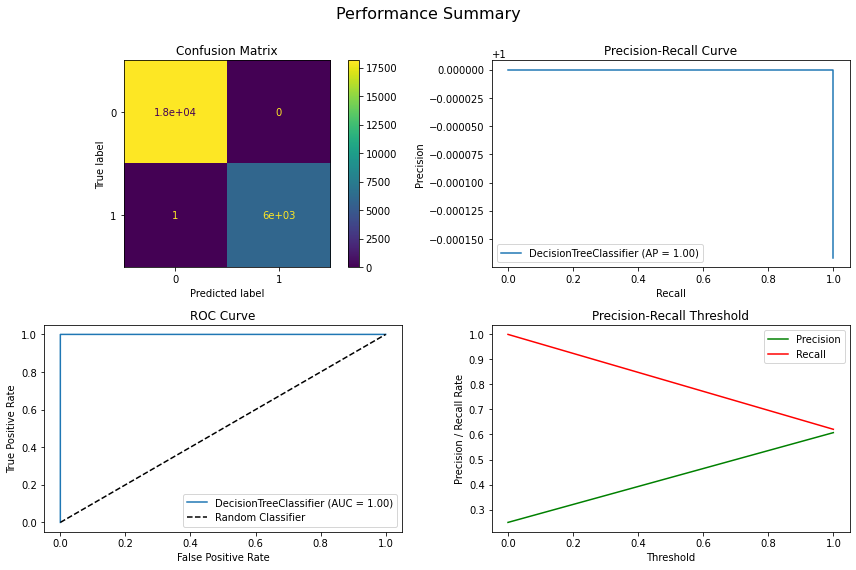

In [13]:
# Performance on Training Data
ml_metrics.classifier_performance_report(dt_clf, X_train, y_train)
# Decision Trees have the propensity to overfit the data, hence the result is not suprising

-----Performance Summary-----
Accuracy Rate: 81.3%
Precision Rate: 62.2%
Recall Rate: 63.9%
F1 Score: 63.1%

Misc. Info:
Number of data points in X: 6033



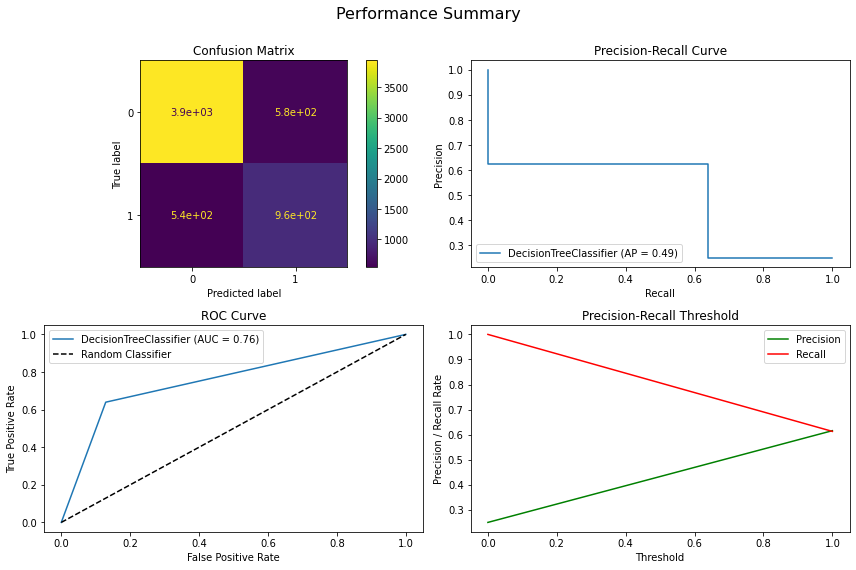

In [14]:
# Performance on Testing Data
ml_metrics.classifier_performance_report(dt_clf, X_test, y_test)

# Base Model Fine-Tuning

In [15]:
print('Current Settings:')
print(dt_clf.get_depth())
print(dt_clf.get_n_leaves())

Current Settings:
47
3619


In [16]:
dt_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [17]:
parameter_grid = [
                    {'max_depth': [25, 50, 75, 100], 
                    'max_features': [10, 20, 30, 40], 
                    'max_leaf_nodes': [2000,3000,4000],
                    'min_samples_leaf': [250,500,1000,1500],
                    },
                    {'ccp_alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
                    },
                    ]

In [18]:
grid_search_cv = ms.GridSearchCV(dt_clf, parameter_grid, scoring='accuracy', cv= 5, return_train_score= True)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [25, 50, 75, 100],
                      

In [19]:
ml_metrics.grid_search_result_summary(grid_search_cv)

Grid Search Result Summary:
Best Estimator's params: {'max_depth': 25, 'max_features': 20, 'max_leaf_nodes': 2000, 'min_samples_leaf': 250}
Best Estimator's score %: 83.08259277789348
Best Estimator's index: 12
Number of cross-validation: 5
Number of Parameters: 201


Top 15 Parameters by Mean Test Score
                                                                                      Params  \
164  {'max_depth': 100, 'max_features': 20, 'max_leaf_nodes': 4000, 'min_samples_leaf': 250}   
112  {'max_depth': 75, 'max_features': 20, 'max_leaf_nodes': 3000, 'min_samples_leaf': 250}    
160  {'max_depth': 100, 'max_features': 20, 'max_leaf_nodes': 3000, 'min_samples_leaf': 250}   
60   {'max_depth': 50, 'max_features': 20, 'max_leaf_nodes': 2000, 'min_samples_leaf': 250}    
64   {'max_depth': 50, 'max_features': 20, 'max_leaf_nodes': 3000, 'min_samples_leaf': 250}    
20   {'max_depth': 25, 'max_features': 20, 'max_leaf_nodes': 4000, 'min_samples_leaf': 250}    
116  {'max_depth': 75,

-----Performance Summary-----
Accuracy Rate: 84.5%
Precision Rate: 74.0%
Recall Rate: 58.7%
F1 Score: 65.5%

Misc. Info:
Number of data points in X: 6033



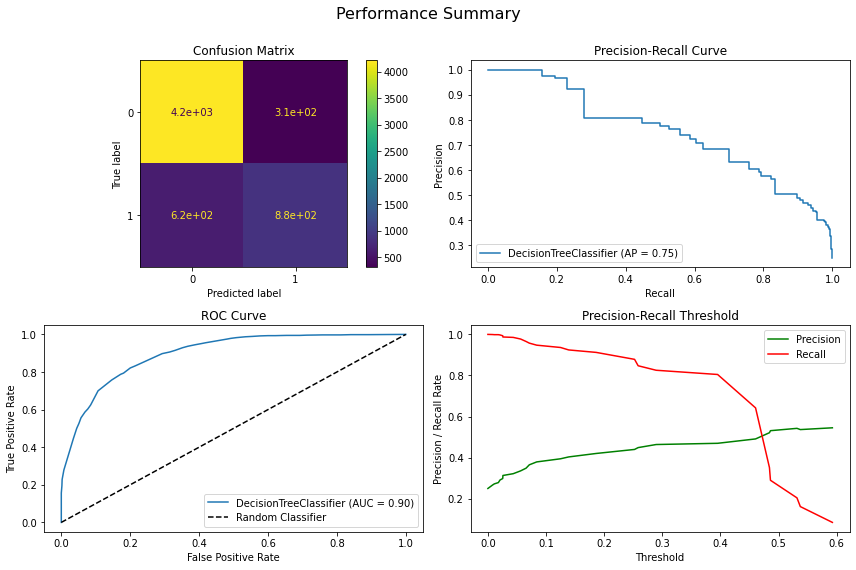

In [20]:
# Performance on Testing Data
ml_metrics.classifier_performance_report(grid_search_cv.best_estimator_, X_test, y_test)

Commentary:
* After fine-tuning, the base model's accuracy increase marginally from 81.3% to 82.8%
* Precision rate increase by much larger margin of about 8% from 63.2% to 71.3%
* The recall rate decrease from 62.9% to 54.1%

# Alternative Model - Random Forest

In [21]:
rf_clf = ensemble.RandomForestClassifier(random_state=42, oob_score=True)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [22]:
print('Out-of-Bag Score:')
print(rf_clf.oob_score_*100)

Out-of-Bag Score:
84.69891002528078


-----Performance Summary-----
Accuracy Rate: 100.0%
Precision Rate: 100.0%
Recall Rate: 100.0%
F1 Score: 100.0%

Misc. Info:
Number of data points in X: 24129



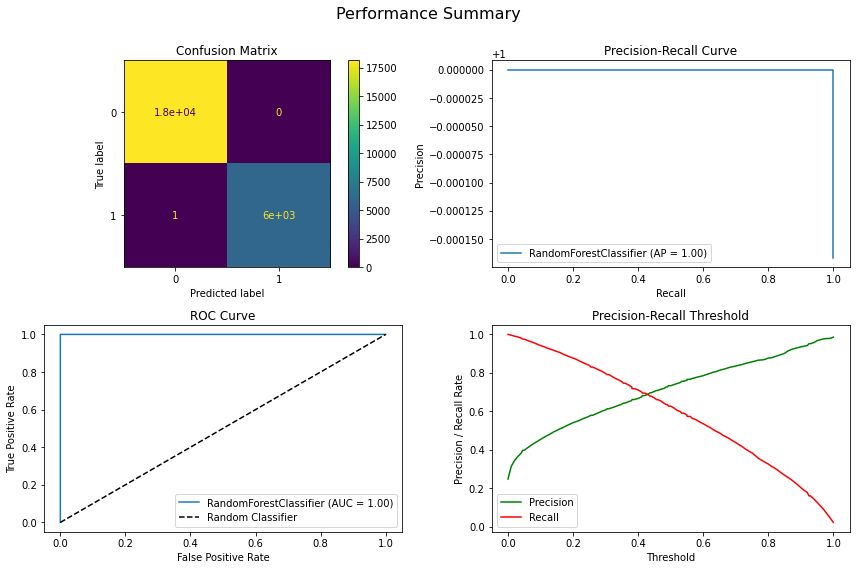

In [23]:
# Performance on Training Data
ml_metrics.classifier_performance_report(rf_clf, X_train, y_train)

-----Performance Summary-----
Accuracy Rate: 86.3%
Precision Rate: 76.5%
Recall Rate: 65.3%
F1 Score: 70.5%

Misc. Info:
Number of data points in X: 6033



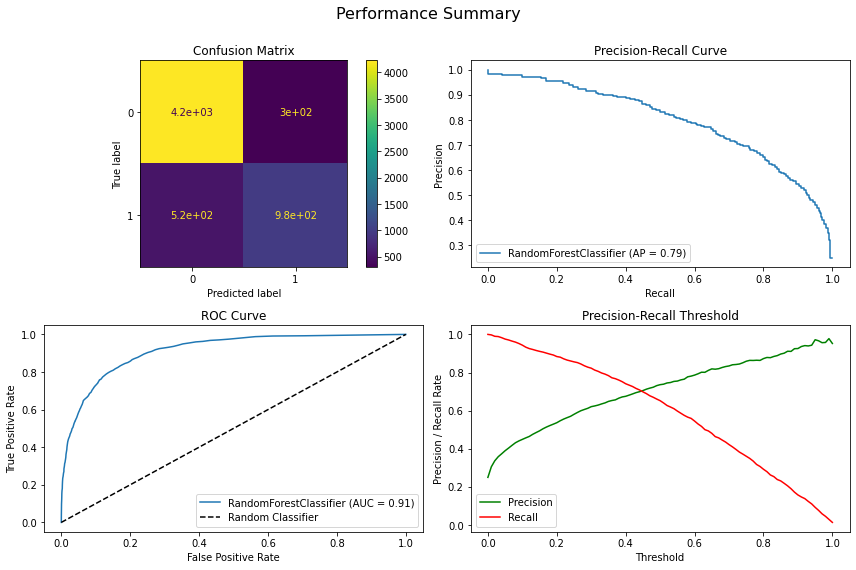

In [24]:
# Performance on Testing Data
ml_metrics.classifier_performance_report(rf_clf, X_test, y_test)

# Random Forest Fine-Tuning

In [25]:
print('Current Settings:')
print(rf_clf.n_estimators)
print(rf_clf.max_depth)
print(rf_clf.max_leaf_nodes)

Current Settings:
100
None
None


In [26]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [27]:
parameter_grid = [
                {'n_estimators': [50,100,150,200,250],
                'max_depth': [50,100,150,200,250],
                'max_features': [10,20,30,40,50],
                'min_samples_leaf': [250,500,1000,1500],
                },
                {'ccp_alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
                },
                ]

In [28]:
grid_search_cv = ms.GridSearchCV(rf_clf, parameter_grid, scoring='accuracy', cv= 5, return_train_score= True)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [29]:
ml_metrics.grid_search_result_summary(grid_search_cv)

Grid Search Result Summary:
Best Estimator's params: {'max_depth': 50, 'max_features': 30, 'min_samples_leaf': 250, 'n_estimators': 100}
Best Estimator's score %: 83.90317816490557
Best Estimator's index: 41
Number of cross-validation: 5
Number of Parameters: 509


Top 15 Parameters by Mean Test Score
                                                                                   Params  \
341  {'max_depth': 200, 'max_features': 30, 'min_samples_leaf': 250, 'n_estimators': 100}   
141  {'max_depth': 100, 'max_features': 30, 'min_samples_leaf': 250, 'n_estimators': 100}   
441  {'max_depth': 250, 'max_features': 30, 'min_samples_leaf': 250, 'n_estimators': 100}   
241  {'max_depth': 150, 'max_features': 30, 'min_samples_leaf': 250, 'n_estimators': 100}   
41   {'max_depth': 50, 'max_features': 30, 'min_samples_leaf': 250, 'n_estimators': 100}    
42   {'max_depth': 50, 'max_features': 30, 'min_samples_leaf': 250, 'n_estimators': 150}    
142  {'max_depth': 100, 'max_features': 30, 'm

-----Performance Summary-----
Accuracy Rate: 84.9%
Precision Rate: 76.5%
Recall Rate: 56.8%
F1 Score: 65.2%

Misc. Info:
Number of data points in X: 6033



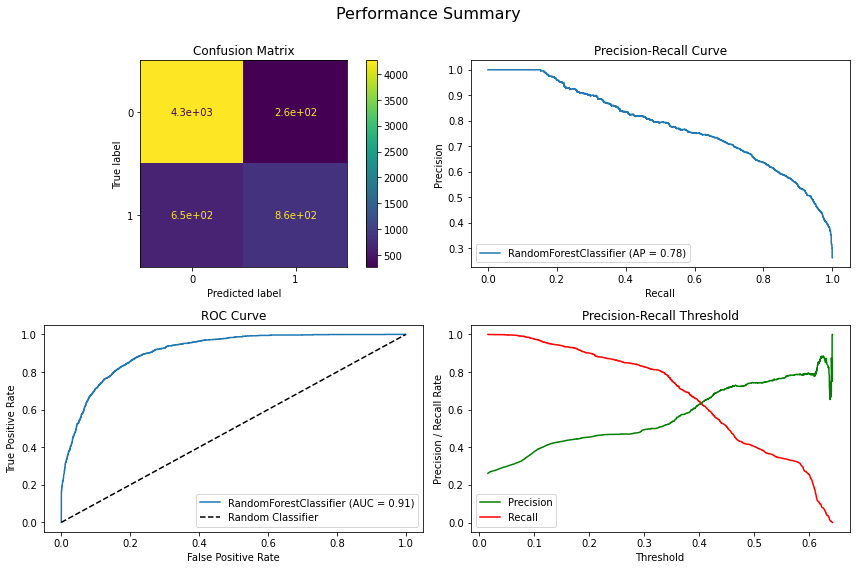

In [30]:
# Performance on Testing Data
ml_metrics.classifier_performance_report(grid_search_cv.best_estimator_, X_test, y_test)

## Overall Summary


|             Model             	| Accuracy 	| Precision 	| Recall 	| F1 Score 	|
|:-----------------------------:	|:--------:	|:---------:	|:------:	|:--------:	|
| Decision Tree (Before-tuning) 	|   81.3   	|    62.2   	|  63.9  	|   63.1   	|
|  Decision Tree (After-tuning) 	|   84.5   	|     74    	|  58.8  	|   65.5   	|
| Random-Forest (Before-tuning) 	|   86.3   	|    76.5   	|  65.3  	|   70.5   	|
|  Random-Forest (After-tuning) 	|   84.9   	|    76.5   	|  56.8  	|   65.2   	|


* Random Forest model with no hyperparameter tuning seems to perform the best
* Interestingly, the recall rate of the Random Forest model with hyperparameter tuning declined from 65.3% before hyperparameter tuning to 56.8% after hyperparameter tuning